In [9]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from mpi4py import MPI
import pickle


# torch
import torch
import torch.nn as nn

# quimb
import quimb.tensor as qtn
import autoray as ar

from vmc_torch.experiment.tn_model import *
from vmc_torch.variational_state import Variational_State
# from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.fermion_utils import generate_random_fpeps
from vmc_torch.utils import closest_divisible

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(8)
Ly = int(8)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = 1024
dtype=torch.float64

# Load PEPS
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/data'
try:
    skeleton = pickle.load(open(f"{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=42, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps.exponent = 0
peps.apply_to_arrays(lambda x: torch.tensor(8*x, dtype=dtype))
for ts in peps.tensors:
    ts.data.phase_sync(inplace=True)

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

In [10]:
# from vmc_torch.experiment.tn_model import wavefunctionModel
# import ast
# import cotengra as ctg
# class fTNModel_reuse(wavefunctionModel):
#     def __init__(self, ftn, max_bond=None, dtype=torch.float32, functional=False, debug=False):
#         super().__init__()
#         self.param_dtype = dtype
#         self.functional = functional
#         self.debug = debug
#         # extract the raw arrays and a skeleton of the TN
#         params, self.skeleton = qtn.pack(ftn)
#         self.skeleton.exponent = 0

#         # Flatten the dictionary structure and assign each parameter as a part of a ModuleDict
#         self.torch_tn_params = nn.ModuleDict({
#             str(tid): nn.ParameterDict({
#                 str(sector): nn.Parameter(data)
#                 for sector, data in blk_array.items()
#             })
#             for tid, blk_array in params.items()
#         })

#         # Get symmetry
#         self.symmetry = ftn.arrays[0].symmetry

#         # Store the shapes of the parameters
#         self.param_shapes = [param.shape for param in self.parameters()]

#         self.model_structure = {
#             f'fPEPS (chi={max_bond})':{'D': ftn.max_bond(), 'Lx': ftn.Lx, 'Ly': ftn.Ly, 'symmetry': self.symmetry},
#         }
#         if max_bond is None or max_bond <= 0:
#             max_bond = None
#         self.max_bond = max_bond
#         self.tree = None
#         self.Lx = ftn.Lx
#         self.Ly = ftn.Ly
#         self._env_x_cache = None
#         self._env_y_cache = None
#         self.config_ref = None
#         self.amp_ref = None
    
#     def from_1d_to_2d(self, config, ordering='snake'):
#         if ordering == 'snake':
#             config_2d = config.reshape((self.Lx, self.Ly))
#             return config_2d
#         else:
#             raise NotImplementedError(f'Ordering {ordering} is not implemented.')
        
#     def from_1dsite_to_2dsite(self, site, ordering='snake'):
#         """
#             Convert a 1d site index to a 2d site index.
#             site: 1d site index
#         """
#         if ordering == 'snake':
#             return (site // self.Ly, site % self.Ly)
#         else:
#             raise ValueError(f"Unsupported ordering: {ordering}")
    
#     def transform_quimb_env_x_key_to_config_key(self, env_x, config):
#         """
#             Return a dictionary with the keys of of the config rows
#         """
#         config_2d = self.from_1d_to_2d(config)
#         env_x_row_config = {}
#         for key in env_x.keys():
#             if key[0] == 'xmax': # from bottom to top
#                 row_n = key[1]
#                 if row_n != self.Lx-1:
#                     rows_config = tuple(torch.cat(tuple(config_2d[row_n+1:].to(torch.int))).tolist())
#                     env_x_row_config[('xmax', rows_config)] = env_x[key]
#             elif key[0] == 'xmin': # from top to bottom
#                 row_n = key[1]
#                 if row_n != 0:
#                     rows_config = tuple(torch.cat(tuple(config_2d[:row_n].to(torch.int))).tolist())
#                     env_x_row_config[('xmin', rows_config)] = env_x[key]
#         return env_x_row_config
    
#     def transform_quimb_env_y_key_to_config_key(self, env_y, config):
#         """
#             Return a dictionary with the keys of of the config rows
#         """
#         config_2d = self.from_1d_to_2d(config)
#         env_y_row_config = {}
#         for key in env_y.keys():
#             if key[0] == 'ymax':
#                 col_n = key[1]
#                 if col_n != self.Ly-1:
#                     cols_config = tuple(torch.cat(tuple(config_2d[:, col_n+1:].to(torch.int))).tolist())
#                     env_y_row_config[('ymax', cols_config)] = env_y[key]
#             elif key[0] == 'ymin':
#                 col_n = key[1]
#                 if col_n != 0:
#                     cols_config = tuple(torch.cat(tuple(config_2d[:, :col_n].to(torch.int))).tolist())
#                     env_y_row_config[('ymin', cols_config)] = env_y[key]
#         return env_y_row_config

#     def cache_env_x(self, amp, config):
#         """
#             Cache the environment x for the given configuration
#         """
#         env_x = amp.compute_x_environments(max_bond=self.max_bond, cutoff=0.0)
#         env_x_cache = self.transform_quimb_env_x_key_to_config_key(env_x, config)
#         self._env_x_cache = env_x_cache
#         self.config_ref = config
#         self.amp_ref = amp
    
#     def cache_env_y(self, amp, config):
#         env_y = amp.compute_y_environments(max_bond=self.max_bond, cutoff=0.0)
#         env_y_cache = self.transform_quimb_env_y_key_to_config_key(env_y, config)
#         self._env_y_cache = env_y_cache
#         self.config_ref = config
#         self.amp_ref = amp
    
#     def cache_env(self, amp, config):
#         """
#             Cache the environment x and y for the given configuration
#         """
#         self.cache_env_x(amp, config)
#         self.cache_env_y(amp, config)
        
#     @property
#     def env_x_cache(self):
#         """
#             Return the cached environment x
#         """
#         if hasattr(self, '_env_x_cache'):
#             return self._env_x_cache
#         else:
#             return None
        
#     @property
#     def env_y_cache(self):
#         """
#             Return the cached environment y
#         """
#         if hasattr(self, '_env_y_cache'):
#             return self._env_y_cache
#         else:
#             return None
    
#     def clear_env_x_cache(self):
#         """
#             Clear the cached environment x
#         """
#         self._env_x_cache = None

#     def clear_env_y_cache(self):
#         """
#             Clear the cached environment y
#         """
#         self._env_y_cache = None
    
#     def clear_wavefunction_env_cache(self):
#         self.clear_env_x_cache()
#         self.clear_env_y_cache()
#         self.config_ref = None
#         self.amp_ref = None
    
#     def detect_changed_sites(self, config_ref, new_config):
#         """
#             Detect the sites that have changed in the new configuration,
#             written in 1d coordinate format.
#         """
#         changed_sites = set()
#         unchanged_sites = set()
#         for i in range(self.Lx * self.Ly):
#             if config_ref[i] != new_config[i]:
#                 changed_sites.add(i)
#             else:
#                 unchanged_sites.add(i)
#         changed_sites = sorted(changed_sites)
#         unchanged_sites = sorted(unchanged_sites)
#         if len(changed_sites) == 0:
#             return [], []
#         return changed_sites, unchanged_sites

#     def from_1d_sites_to_tids(self, sites):
#         """
#             Convert a list of 1d site indices to a list of tensor ids.
#         """
#         tids_list = list(self.skeleton.tensor_map.keys())
#         return [tids_list[site] for site in sites]
    
#     def detect_changed_rows(self, config_ref, new_config):
#         """
#             Detect the rows that have changed in the new configuration
#         """
#         config_ref_2d = self.from_1d_to_2d(config_ref)
#         new_config_2d = self.from_1d_to_2d(new_config)
#         changed_rows = []
#         for i in range(self.Lx):
#             if not torch.equal(config_ref_2d[i], new_config_2d[i]):
#                 changed_rows.append(i)
#         if len(changed_rows) == 0:
#             return [], [], []
#         unchanged_rows_above = list(range(changed_rows[0]))
#         unchanged_rows_below = list(range(changed_rows[-1]+1, self.Lx))
#         return changed_rows, unchanged_rows_above, unchanged_rows_below
    
#     def detect_changed_cols(self, config_ref, new_config):
#         """
#             Detect the columns that have changed in the new configuration
#         """
#         config_ref_2d = self.from_1d_to_2d(config_ref)
#         new_config_2d = self.from_1d_to_2d(new_config)
#         changed_cols = []
#         for i in range(self.Ly):
#             if not torch.equal(config_ref_2d[:, i], new_config_2d[:, i]):
#                 changed_cols.append(i)
#         if len(changed_cols) == 0:
#             return [], [], []
#         unchanged_cols_left = list(range(changed_cols[0]))
#         unchanged_cols_right = list(range(changed_cols[-1]+1, self.Ly))
#         return changed_cols, unchanged_cols_left, unchanged_cols_right
    
#     def update_env_x_cache(self, config):
#         """
#             Update the cached environment x for the given configuration
#         """
#         if self.env_x_cache is not None:
#             self.clear_env_x_cache()
#         amp_tn = self.get_amp_tn(config)
#         self.cache_env_x(amp_tn, config)
#         self.config_ref = config
#         self.amp_ref = amp_tn
    
#     def update_env_x_cache_to_row(self, config, row_id, from_which='xmin'):
#         amp_tn = self.get_amp_tn(config)
#         new_env_x = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, xrange=(0, row_id+1) if from_which=='xmin' else (row_id-1, self.Lx-1), from_which=from_which)
#         new_env_x_cache = self.transform_quimb_env_x_key_to_config_key(new_env_x, config)
#         # add the new env_x to the cache
#         if self.env_x_cache is None:
#             self._env_x_cache = new_env_x_cache
#         else:
#             self._env_x_cache.update(new_env_x_cache)
#         self.config_ref = config
#         self.amp_ref = amp_tn
    
#     def update_env_y_cache(self, config):
#         """
#             Update the cached environment y for the given configuration
#         """
#         if self.env_y_cache is not None:
#             self.clear_env_y_cache()
#         amp_tn = self.get_amp_tn(config)
#         self.cache_env_y(amp_tn, config)
#         self.config_ref = config
#         self.amp_ref = amp_tn
    
#     def update_env_y_cache_to_col(self, config, col_id, from_which='ymin'):
#         amp_tn = self.get_amp_tn(config)
#         new_env_y = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, yrange=(0, col_id+1) if from_which=='ymin' else (col_id-1, self.Ly-1), from_which=from_which)
#         new_env_y_cache = self.transform_quimb_env_y_key_to_config_key(new_env_y, config)
#         # add the new env_y to the cache
#         if self.env_y_cache is None:
#             self._env_y_cache = new_env_y_cache
#         else:
#             self._env_y_cache.update(new_env_y_cache)
#         self.config_ref = config
#         self.amp_ref = amp_tn
    
#     def psi(self):
#         """
#             Return the wavefunction (fPEPS)
#         """
#         # Reconstruct the original parameter structure (by unpacking from the flattened dict)
#         params = {
#             int(tid): {
#                 ast.literal_eval(sector): data
#                 for sector, data in blk_array.items()
#             }
#             for tid, blk_array in self.torch_tn_params.items()
#         }
#         # Reconstruct the TN with the new parameters
#         psi = qtn.unpack(params, self.skeleton)
#         return psi

#     def get_local_amp_tensors(self, sites:list, config:torch.Tensor):
#         """
#             Get the local tensors for the given tensor ids and configuration.
#             tids: a list of tensor ids. list of int.
#             config: the input configuration.
#         """
#         # first pick out the tensor parameters and form the local tn parameters vector
#         local_ts_params = {}
#         tids = self.from_1d_sites_to_tids(sites)
#         for tid in tids:
#             local_ts_params[tid] = {
#                 ast.literal_eval(sector): data
#                 for sector, data in self.torch_tn_params[str(tid)].items()
#             }
        
#         # Get sites corresponding to the tids
#         sites_2d = [self.from_1dsite_to_2dsite(site) for site in sites]

#         # Select the corresponding tensor skeleton
#         local_ts_skeleton = self.skeleton.select([self.skeleton.site_tag_id.format(*site) for site in sites_2d], which='any')

#         # Reconstruct the TN with the new parameters
#         local_ftn = qtn.unpack(local_ts_params, local_ts_skeleton)

#         # Fix the physical indices
#         return local_ftn.fix_phys_inds(sites_2d, config[sites])
    
#     def get_amp_tn(self, config, reconstruct=False):

#         if self.amp_ref is None or reconstruct:
#             psi = self.psi()
#             # Check config type
#             if not type(config) == torch.Tensor:
#                 config = torch.tensor(config, dtype=torch.int if self.functional else self.param_dtype)
#             else:
#                 if config.dtype != self.param_dtype:
#                     config = config.to(torch.int if self.functional else self.param_dtype)
#             # Get the amplitude
#             amp_tn = psi.get_amp(config, conj=True, functional=self.functional)
#             return amp_tn
        
#         else:
#             # detect the sites that have changed
#             changed_sites, unchanged_sites = self.detect_changed_sites(self.config_ref, config)

#             if len(changed_sites) == 0:
#                 return self.amp_ref
#             else:
#                 # substitute the changed sites tensors
#                 local_amp_tn = self.get_local_amp_tensors(changed_sites, config)
#                 unchanged_sites_2d = [self.from_1dsite_to_2dsite(site) for site in unchanged_sites]
#                 unchanged_sites_tags = [self.skeleton.site_tag_id.format(*site) for site in unchanged_sites_2d]
#                 unchanged_amp_tn = self.amp_ref.select(unchanged_sites_tags, which='any')
#                 # merge the local_amp_tn and unchanged_amp_tn
#                 amp_tn = local_amp_tn | unchanged_amp_tn
#                 return amp_tn
    
#     def amplitude(self, x):
#         # Reconstruct the original parameter structure (by unpacking from the flattened dict)
#         params = {
#             int(tid): {
#                 ast.literal_eval(sector): data
#                 for sector, data in blk_array.items()
#             }
#             for tid, blk_array in self.torch_tn_params.items()
#         }
#         # Reconstruct the TN with the new parameters
#         psi = qtn.unpack(params, self.skeleton)
#         # `x` is expected to be batched as (batch_size, input_dim)
#         # Loop through the batch and compute amplitude for each sample
#         batch_amps = []
#         for x_i in x:
#             # Check x_i type
#             if not type(x_i) == torch.Tensor:
#                 x_i = torch.tensor(x_i, dtype=torch.int if self.functional else self.param_dtype)
#             else:
#                 if x_i.dtype != self.param_dtype:
#                     x_i = x_i.to(torch.int if self.functional else self.param_dtype)
#             # Get the amplitude
#             # amp = psi.get_amp(x_i, conj=True, functional=self.functional)
#             amp = self.get_amp_tn(x_i)

#             if self.max_bond is None:
#                 amp = amp
#                 if self.tree is None:
#                     opt = ctg.HyperOptimizer(progbar=True, max_repeats=10, parallel=True)
#                     self.tree = amp.contraction_tree(optimize=opt)
#                 amp_val = amp.contract(optimize=self.tree)

#             else:
#                 if self.cache_env_mode:
#                     self.cache_env_x(amp, x_i)
#                     # self.cache_env_y(amp, x_i)
#                     self.config_ref = x_i
#                     config_2d = self.from_1d_to_2d(x_i)
#                     key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[self.Lx//2:].to(torch.int))).tolist()))
#                     key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:self.Lx//2].to(torch.int))).tolist()))
#                     amp_bot = self.env_x_cache[key_bot]
#                     amp_top = self.env_x_cache[key_top]
#                     amp_val = (amp_bot|amp_top).contract()
                    

#                 else:
#                     if self.env_x_cache is None and self.env_y_cache is None:
#                         # check whether we can reuse the cached environment
#                         amp = amp.contract_boundary_from_ymin(max_bond=self.max_bond, cutoff=0.0, yrange=[0, psi.Ly//2-1])
#                         amp = amp.contract_boundary_from_ymax(max_bond=self.max_bond, cutoff=0.0, yrange=[psi.Ly//2, psi.Ly-1])
#                         amp_val = amp.contract()
#                     else:
#                         config_2d = self.from_1d_to_2d(x_i)
#                         # detect the rows that have changed
#                         changed_rows, unchanged_rows_above, unchanged_rows_below = self.detect_changed_rows(self.config_ref, x_i)
#                         # detect the columns that have changed
#                         changed_cols, unchanged_cols_left, unchanged_cols_right = self.detect_changed_cols(self.config_ref, x_i)
#                         if len(changed_rows) == 0:
#                             key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[self.Lx//2:].to(torch.int))).tolist()))
#                             key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:self.Lx//2].to(torch.int))).tolist()))
#                             amp_bot = self.env_x_cache[key_bot]
#                             amp_top = self.env_x_cache[key_top]
#                             amp_val = (amp_bot|amp_top).contract()
#                         else:
#                             if len(changed_rows) <= len(changed_cols):
#                                 # for bottom envs, until the last row in the changed rows, we can reuse the env
#                                 # for top envs, until the first row in the changed rows, we can reuse the env
#                                 amp_changed_rows = qtn.TensorNetwork([amp.select(amp.x_tag_id.format(row_n)) for row_n in changed_rows])
#                                 amp_unchanged_bottom_env = qtn.TensorNetwork()
#                                 amp_unchanged_top_env = qtn.TensorNetwork()
#                                 if len(unchanged_rows_below) != 0:
#                                     amp_unchanged_bottom_env = self.env_x_cache[('xmax', tuple(torch.cat(tuple(config_2d[unchanged_rows_below].to(torch.int))).tolist()))]
#                                 if len(unchanged_rows_above) != 0:
#                                     amp_unchanged_top_env = self.env_x_cache[('xmin', tuple(torch.cat(tuple(config_2d[unchanged_rows_above].to(torch.int))).tolist()))]
#                                 amp_val = (amp_unchanged_bottom_env|amp_unchanged_top_env|amp_changed_rows).contract()
#                                 # print(f'changed rows: {changed_rows}', self.from_1d_to_2d(x_i), self.from_1d_to_2d(self.config_ref))
#                             else:
#                                 # for left envs, until the first column in the changed columns, we can reuse the env
#                                 # for right envs, until the last column in the changed columns, we can reuse the env
#                                 amp_changed_cols = qtn.TensorNetwork([amp.select(amp.y_tag_id.format(col_n)) for col_n in changed_cols])
#                                 amp_unchanged_left_env = qtn.TensorNetwork()
#                                 amp_unchanged_right_env = qtn.TensorNetwork()
#                                 if len(unchanged_cols_left) != 0:
#                                     amp_unchanged_left_env = self.env_y_cache[('ymin', tuple(torch.cat(tuple(config_2d[:, unchanged_cols_left].to(torch.int))).tolist()))]
#                                 if len(unchanged_cols_right) != 0:
#                                     amp_unchanged_right_env = self.env_y_cache[('ymax', tuple(torch.cat(tuple(config_2d[:, unchanged_cols_right].to(torch.int))).tolist()))]
#                                 amp_val = (amp_unchanged_left_env|amp_unchanged_right_env|amp_changed_cols).contract()
                                
#             if amp_val==0.0:
#                 amp_val = torch.tensor(0.0)
            
#             if self.debug:
#                 print(f'Reused Amp val: {amp_val}, Exact Amp val: {self.get_amp_tn(x_i).contract()}')
            
#             batch_amps.append(amp_val)

#         # Return the batch of amplitudes stacked as a tensor
#         return torch.stack(batch_amps)

In [11]:
# reusable fPEPS model
random_x = torch.tensor(H.hilbert.random_state())
random_x1 = random_x.clone()
print(random_x)
random_x1[2] = 1
random_x1[3] = 2

# print((peps.product_bra_state(random_x).conj()|peps).contract(), (peps|peps.product_bra_state(random_x, reverse=1)).contract())

# permute_list = []
# for tensor in peps.product_bra_state(random_x).conj().tensors:
#     # print(tensor.data.charge, tensor.data.oddpos)
#     if len(tensor.data.oddpos)>0:
#         # print(tensor.data.oddpos[0].label, tensor.data.oddpos[0].dual)
#         permute_list.append(tensor.data.oddpos[0].label)

# # sort the list and note down the parity of the permutation
# print(len(permute_list))
# # sum from len(permute_list) to 1
# N = 0
# for i in range(len(permute_list)):
#     N += i
# print('phase correction from reversing the ordering:', (-1)**(N%2))

from vmc_torch.sampler import *

model = fTNModel_reuse(peps, max_bond=chi, dtype=dtype, debug=True)
# model = fTNModel(peps, max_bond=chi, dtype=dtype)

sampled_x = torch.tensor([3, 1, 1, 0, 1, 2, 2, 0, 2, 3, 1, 1, 2, 2, 3, 2, 2, 3, 2, 0, 1, 3, 3, 2,
        2, 1, 1, 1, 0, 3, 0, 2, 3, 1, 1, 3, 0, 2, 1, 3, 1, 0, 0, 0, 2, 3, 0, 0,
        0, 1, 1, 0, 3, 3, 2, 2, 3, 3, 3, 0, 0, 2, 1, 0])

sampler = MetropolisExchangeSamplerSpinful_2D_reusable(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=False, equal_partition=False, dtype=dtype)
# sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=10, reset_chain=False, random_edge=False, equal_partition=False, dtype=dtype)
vstate = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
# t0 = time.time()
sampled_x, sampled_amp = sampler._sample_next(vstate, burn_in=False)
vstate.set_cache_env_mode(on=True)
amp, grad = vstate.amplitude_grad(sampled_x, retain_graph=True)
vstate.set_cache_env_mode(on=False)
# t1 = time.time()

tensor([0, 3, 3, 1, 2, 0, 3, 0, 2, 0, 2, 2, 0, 3, 0, 1, 3, 2, 1, 1, 1, 0, 3, 1,
        1, 3, 1, 1, 3, 3, 3, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 1,
        1, 2, 2, 0, 3, 3, 2, 2, 1, 0, 2, 1, 2, 1, 2, 3])
Reused Amp val: -15864435787.480804, Exact Amp val: -15864435787.544909, Rel error: 4.040741256649235e-12
Reused Amp val: 107415504489.87418, Exact Amp val: 107415504489.87875, Rel error: 4.2616163658025076e-14
Reused Amp val: -72370525972.30078, Exact Amp val: -72370525972.30498, Rel error: 5.79817119719885e-14
Reused Amp val: -11231692254.0059, Exact Amp val: -11231692254.007483, Rel error: 1.4094931818217535e-13
Reused Amp val: 68366055836.32291, Exact Amp val: 68366055836.31947, Rel error: 5.0218306395826883e-14
Reused Amp val: -14480462517.648745, Exact Amp val: -14480462517.649925, Rel error: 8.153391525110955e-14
Reused Amp val: -286545156412.25214, Exact Amp val: -286545156412.2915, Rel error: 1.3738733634222163e-13
Reused Amp val: -18777926557.78307, Exact Amp val

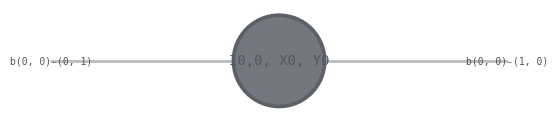

In [12]:
from vmc_torch.fermion_utils import flatten_fts_params
from vmc_torch.fermion_utils import reconstruct_fts_params
amp_tn = model.get_amp_tn(sampled_x)
ts0 = amp_tn.select('I0,0').contract()
ts0.draw()
ts_params = flatten_fts_params(ts0.get_params())

ts_left = [ts for ts in amp_tn.tensors if 'I0,0' not in ts.tags]
tn_left = qtn.TensorNetwork(ts_left)
grad_ts = tn_left.contract()
grad_ts.data.phase_sync(inplace=True) # BUG: should take into account the fermion signs generated in the final contraction!!

grad_ts_params = flatten_fts_params(grad_ts.get_params())
# ts0.data.blocks, grad_ts.data.blocks

In [13]:
grad_ts_params/amp

tensor([ 9.2773e-03, -5.8453e-17, -1.6371e-16, -3.4835e-03, -2.2166e-01,
         6.7281e-02, -7.5713e-02,  2.1937e-02], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [ ]:
model.clear_grad()
amp_val = model.get_amp_tn(sampled_x).contract()
amp_val.backward(retain_graph=True)
grad_vec0 = []
for param in model.parameters():
    if param.grad is None:
        # print(None)
        ...
    else:
        # print(param.grad/amp_val)
        grad_vec0.append(param.grad/amp_val)
model.clear_grad()
# grad_vec0
# print(model.get_amp_tn(sampled_x).contract())
max_g = 0
for grad_ts in grad_vec0:
    if grad_ts is not None:
        max_g = max(max_g, torch.max(torch.abs(grad_ts)))
print('Max grad:', max_g)

In [19]:
model.clear_grad()
# config_2d = model.from_1d_to_2d(sampled_x)
# model._env_x_cache = None
# model._env_y_cache = None
model.cache_env_mode = True
amp0 = model(sampled_x)
# key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[model.Lx//2:].to(torch.int))).tolist()))
# key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:model.Lx//2].to(torch.int))).tolist()))
# amp_bot = model.env_x_cache[key_bot]
# amp_top = model.env_x_cache[key_top]
# amp_val = (amp_bot|amp_top).contract()*10**(model.skeleton.exponent)
# amp_val.backward(retain_graph=True)
amp0.backward(retain_graph=True)

# amp_tn = model.get_amp_tn(sampled_x)
# amp = amp_tn.contract_boundary_from_xmin(max_bond=model.max_bond, cutoff=0.0, xrange=[0, model.Lx//2-1])
# amp = amp.contract_boundary_from_xmax(max_bond=model.max_bond, cutoff=0.0, xrange=[model.Lx//2, model.Lx-1])
# amp_val1 = amp.contract()
# amp_val1.backward(retain_graph=True)

grad_vec1 = []
for param in model.parameters():
    if param.grad is None:
        # print(None)
        ...
    else:
        # print(param.grad/amp0)
        grad_vec1.append(param.grad/amp0)

model.clear_grad()
max_g = 0
for grad_ts in grad_vec1:
    if grad_ts is not None:
        max_g = max(max_g, torch.max(torch.abs(grad_ts)))
print('Max grad:', max_g)

Reused Amp val: -6.077216771498784e+23, Exact Amp val: -6.077216771498737e+23, Rel error: 7.729887967846e-15
Max grad: tensor(2.0198, dtype=torch.float64, grad_fn=<MaxBackward1>)


In [16]:
print(torch.allclose(amp0, amp_val))
for i in range(len(grad_vec1)):
    # show rel err in percentage
    print(f'grad_vec0[{i}]-grad_vec1[{i}]: {torch.norm(grad_vec0[i]-grad_vec1[i])/torch.norm(grad_vec0[i]) * 100:.2f}%')

True
grad_vec0[0]-grad_vec1[0]: 0.00%
grad_vec0[1]-grad_vec1[1]: 0.00%
grad_vec0[2]-grad_vec1[2]: 0.00%
grad_vec0[3]-grad_vec1[3]: 0.00%
grad_vec0[4]-grad_vec1[4]: 0.00%
grad_vec0[5]-grad_vec1[5]: 0.00%
grad_vec0[6]-grad_vec1[6]: 0.00%
grad_vec0[7]-grad_vec1[7]: 0.00%
grad_vec0[8]-grad_vec1[8]: 0.00%
grad_vec0[9]-grad_vec1[9]: 0.00%
grad_vec0[10]-grad_vec1[10]: 0.00%
grad_vec0[11]-grad_vec1[11]: 0.00%
grad_vec0[12]-grad_vec1[12]: 0.00%
grad_vec0[13]-grad_vec1[13]: 0.00%
grad_vec0[14]-grad_vec1[14]: 0.00%
grad_vec0[15]-grad_vec1[15]: 0.00%
grad_vec0[16]-grad_vec1[16]: 0.00%
grad_vec0[17]-grad_vec1[17]: 0.00%
grad_vec0[18]-grad_vec1[18]: 0.00%
grad_vec0[19]-grad_vec1[19]: 0.00%
grad_vec0[20]-grad_vec1[20]: 0.00%
grad_vec0[21]-grad_vec1[21]: 0.00%
grad_vec0[22]-grad_vec1[22]: 0.00%
grad_vec0[23]-grad_vec1[23]: 0.00%
grad_vec0[24]-grad_vec1[24]: 0.00%
grad_vec0[25]-grad_vec1[25]: 0.00%
grad_vec0[26]-grad_vec1[26]: 0.00%
grad_vec0[27]-grad_vec1[27]: 0.00%
grad_vec0[28]-grad_vec1[28]: 0.00%


In [18]:
average_rel_err = 0.0
for rel_contraction_err in model.debug_amp_cache:
    average_rel_err += rel_contraction_err[2]
average_rel_err /= len(model.debug_amp_cache)
# print(f"Average relative contraction error: {average_rel_err} for D={D}, chi={chi}, time={t1-t0:.2f}s, Lx={Lx}, Ly={Ly}, symmetry={symmetry}")

Average relative contraction error: 1.7202865340398485 for D=4, chi=16, time=14.22s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 1.374601678306499 for D=4, chi=64, time=16.01s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 0.10715998841340528 for D=4, chi=128, time=15.06s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 0.0748252922749927 for D=4, chi=160, time=15.44s, Lx=8, Ly=8, symmetry=Z2
Average relative contraction error: 8.601565829643471e-14 for D=4, chi=256, time=16.54s, Lx=8, Ly=8, symmetry=Z2

In [ ]:
# fPEPS w/o reuse
model1 = fTNModel(peps, max_bond=-1, dtype=dtype)
vstate1 = Variational_State(model1, hi=H.hilbert, sampler=sampler, dtype=dtype)
amp1, grad1 = vstate1.amplitude_grad(sampled_x)

F=8.52 C=9.27 S=22.00 P=22.32: 100%|██████████| 10/10 [00:00<00:00, 19.96it/s] 


In [ ]:
assert torch.norm(grad-grad1)<10**(-3)*torch.norm(grad1), f'Gradients are not equal: {torch.norm(grad-grad1)}'
assert torch.norm(amp-amp1)<10**(-3)*torch.norm(amp1), f'Amplitudes are not equal w rel err: {torch.norm(amp-amp1)/ torch.norm(amp1)}'

AssertionError: Gradients are not equal: 0.04582833351407129

In [ ]:
torch.norm(amp-amp1)/torch.norm(amp1), torch.norm(grad-grad1)/torch.norm(grad1)

(tensor(0.0010, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(0.0058, dtype=torch.float64, grad_fn=<DivBackward0>))

In [ ]:
# local energy w reuse
op = H
sigma = sampled_x
psi_sigma = amp
eta, O_etasigma = op.get_conn(sigma)
psi_eta = vstate.amplitude(eta)
psi_sigma = psi_sigma.cpu().detach().numpy()
psi_eta = psi_eta.cpu().detach().numpy()
op_loc = np.sum(O_etasigma * (psi_eta / psi_sigma), axis=-1)
print(f"Local energy with reuse: {op_loc}")

# local energy w/o reuse
op1 = H
sigma1 = sampled_x
psi_sigma1 = amp1
eta1, O_etasigma1 = op1.get_conn(sigma1)
psi_eta1 = vstate1.amplitude(eta1)
psi_sigma1 = psi_sigma1.cpu().detach().numpy()
psi_eta1 = psi_eta1.cpu().detach().numpy()
op_loc1 = np.sum(O_etasigma1 * (psi_eta1 / psi_sigma1), axis=-1)
print(f"Local energy w/o reuse: {op_loc1}")

Local energy with reuse: 117.2844806950575
Local energy w/o reuse: 117.3802497272778


In [ ]:
graph.row_edges, graph.col_edges, graph.edges()

({0: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)],
  1: [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11)],
  2: [(12, 13), (13, 14), (14, 15), (15, 16), (16, 17)],
  3: [(18, 19), (19, 20), (20, 21), (21, 22), (22, 23)],
  4: [(24, 25), (25, 26), (26, 27), (27, 28), (28, 29)],
  5: [(30, 31), (31, 32), (32, 33), (33, 34), (34, 35)]},
 {0: [(0, 6), (6, 12), (12, 18), (18, 24), (24, 30)],
  1: [(1, 7), (7, 13), (13, 19), (19, 25), (25, 31)],
  2: [(2, 8), (8, 14), (14, 20), (20, 26), (26, 32)],
  3: [(3, 9), (9, 15), (15, 21), (21, 27), (27, 33)],
  4: [(4, 10), (10, 16), (16, 22), (22, 28), (28, 34)],
  5: [(5, 11), (11, 17), (17, 23), (23, 29), (29, 35)]},
 [(0, 1),
  (0, 6),
  (1, 2),
  (1, 7),
  (2, 3),
  (2, 8),
  (3, 4),
  (3, 9),
  (4, 5),
  (4, 10),
  (5, 11),
  (6, 7),
  (6, 12),
  (7, 8),
  (7, 13),
  (8, 9),
  (8, 14),
  (9, 10),
  (9, 15),
  (10, 11),
  (10, 16),
  (11, 17),
  (12, 13),
  (12, 18),
  (13, 14),
  (13, 19),
  (14, 15),
  (14, 20),
  (15, 16),
  (15, 21),
  (16, 17),
  (1

In [ ]:
model = fTNModel_reuse(peps, max_bond=chi, dtype=dtype, functional=False)
model.cache_env_mode = True
model(random_x)
model.cache_env_mode = False

In [ ]:
import time
t0 = time.time()
amp0 = model.get_amp_tn(random_x1)
t1 = time.time()
print("Time taken:", t1 - t0)
amp0.contract()

Time taken: 0.0023186206817626953


0.0

In [ ]:
t0 = time.time()
amp1 = model.get_amp_tn(random_x1, reconstruct=True)
t1 = time.time()
print("Time taken:", t1 - t0)
amp1.contract()

Time taken: 0.011317729949951172


0.0

# mode = 'dm':
ImportError: autoray couldn't find function 'argsort' for backend 'symmray'.

##### TO-DO: need to implement eigh_truncate for fermionic tensors

# mode = 'fit'

In [ ]:
amp0.contract_boundary_from_xmax(xrange=(0, model.Lx-1), max_bond=16, cutoff=0.0, mode='fit').contract()

TypeError: Expected FermionicArray, got <class 'numpy.ndarray'>.